<a href="https://colab.research.google.com/github/byunsy/brain-mri-segmentation/blob/main/Brain_MRI_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brain MRI Segmentation


## 01. Import Necessary Packages

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import cv2
from skimage import io

In [ ]:
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import tensorflow.keras.backend as K

In [ ]:
import random
import glob
from sklearn.preprocessing import StandardScaler, normalize
from IPython.display import display

## 02. Attain Dataset from Kaggle

Install Kaggle (`-q` for quiet install)

In [ ]:
!pip install -q kaggle

Upload Kaggle personal API key JSON file.

In [ ]:
from google.colab import files
files.upload()

Create a new directory and move the kaggle API key file into this directory.

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

Change the permission modes.

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

Download the desired kaggle dataset.

In [ ]:
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation

100% 713M/714M [00:05<00:00, 113MB/s]
100% 714M/714M [00:05<00:00, 144MB/s]


Unzip the downloaded dataset file. 

In [ ]:
!unzip /content/lgg-mri-segmentation.zip

## 03. Understanding the Dataset

Create a base directory filepath.

In [ ]:
base_dir = "/content/kaggle_3m"

Remove unnecessary directory and its contents. 

In [ ]:
!rm -r /content/lgg-mri-segmentation

Let's create a list called `data_map` that contains a list of all the directories and all the image files (filepaths) that exist in the base and sub directories. Files that are in the `base_dir` will raise an exception (a README file and csv file).

In [ ]:
data_map = []

for sub_dir_path in glob.glob(os.path.join(base_dir, "*")):

    try:
        dir_name = sub_dir_path.split('/')[-1]
        for filename in os.listdir(sub_dir_path):
            image_path = sub_dir_path + '/' + filename
            data_map.extend([dir_name, image_path])

    except Exception as e:
        print(e)

[Errno 20] Not a directory: '/content/kaggle_3m/README.md'
[Errno 20] Not a directory: '/content/kaggle_3m/data.csv'


We now have data_map as `[dir1, img1, dir2, img2, dir3, img3, ..., dirn, imgn]`

In [ ]:
data_map[:20]

['TCGA_HT_7684_19950816',
 '/content/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_23.tif',
 'TCGA_HT_7684_19950816',
 '/content/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_22.tif',
 'TCGA_HT_7684_19950816',
 '/content/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_2.tif',
 'TCGA_HT_7684_19950816',
 '/content/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_16_mask.tif',
 'TCGA_HT_7684_19950816',
 '/content/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_4_mask.tif',
 'TCGA_HT_7684_19950816',
 '/content/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_24.tif',
 'TCGA_HT_7684_19950816',
 '/content/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_13_mask.tif',
 'TCGA_HT_7684_19950816',
 '/content/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_20_mask.tif',
 'TCGA_HT_7684_19950816',
 '/content/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_7_mask.tif',
 'TCGA_HT_7684_19950816',
 '/content/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7

Using this data_map, we can create a pandas dataframe.

In [ ]:
df = pd.DataFrame({"patient_id" : data_map[::2],
                   "path" : data_map[1::2]})
df

,patient_id,path
0,TCGA_HT_7684_19950816,/content/kaggle_3m/TCGA_HT_7684_19950816/TCGA_...
1,TCGA_HT_7684_19950816,/content/kaggle_3m/TCGA_HT_7684_19950816/TCGA_...
2,TCGA_HT_7684_19950816,/content/kaggle_3m/TCGA_HT_7684_19950816/TCGA_...
3,TCGA_HT_7684_19950816,/content/kaggle_3m/TCGA_HT_7684_19950816/TCGA_...
4,TCGA_HT_7684_19950816,/content/kaggle_3m/TCGA_HT_7684_19950816/TCGA_...
...,...,...
7853,TCGA_DU_6399_19830416,/content/kaggle_3m/TCGA_DU_6399_19830416/TCGA_...
7854,TCGA_DU_6399_19830416,/content/kaggle_3m/TCGA_DU_6399_19830416/TCGA_...
7855,TCGA_DU_6399_19830416,/content/kaggle_3m/TCGA_DU_6399_19830416/TCGA_...
7856,TCGA_DU_6399_19830416,/content/kaggle_3m/TCGA_DU_6399_19830416/TCGA_...


Paths that contains the word "mask" are `df_masks`, otherwise they are `df_images`.

In [ ]:
df_imgs = df[~df['path'].str.contains("mask")]
df_masks = df[df['path'].str.contains("mask")]

In [ ]:
print(len(df_imgs))
print(len(df_masks))

3929
3929


In [ ]:
data_map[:5]

['TCGA_HT_7684_19950816',
 '/content/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_23.tif',
 'TCGA_HT_7684_19950816',
 '/content/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_22.tif',
 'TCGA_HT_7684_19950816']

In [ ]:
len("/content/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_")

63

In [ ]:
# File path line length images for later sorting
BASE_LEN = 63 
END_IMG_LEN = 4 
END_MASK_LEN = 9

# Data sorting
imgs = sorted(df_imgs["path"].values, key=lambda x : int(x[BASE_LEN:-END_IMG_LEN]))
masks = sorted(df_masks["path"].values, key=lambda x : int(x[BASE_LEN:-END_MASK_LEN]))

In [ ]:
# Final dataframe
brain_df = pd.DataFrame({"patient_id": df_imgs.patient_id.values,
                         "image_path": imgs,
                         "mask_path": masks})

# Determines whether the mask has pixels in them
# - some will be blank black images
# - while some will have white pixels
def pos_neg_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0 : 
        return 1
    else:
        return 0
    

brain_df['mask'] = brain_df['mask_path'].apply(lambda x: pos_neg_diagnosis(x))
brain_df

,patient_id,image_path,mask_path,mask
0,TCGA_HT_7684_19950816,/content/kaggle_3m/TCGA_HT_7684_19950816/TCGA_...,/content/kaggle_3m/TCGA_HT_7684_19950816/TCGA_...,0
1,TCGA_HT_7684_19950816,/content/kaggle_3m/TCGA_DU_5849_19950405/TCGA_...,/content/kaggle_3m/TCGA_DU_5849_19950405/TCGA_...,0
2,TCGA_HT_7684_19950816,/content/kaggle_3m/TCGA_DU_5871_19941206/TCGA_...,/content/kaggle_3m/TCGA_DU_5871_19941206/TCGA_...,0
3,TCGA_HT_7684_19950816,/content/kaggle_3m/TCGA_DU_6408_19860521/TCGA_...,/content/kaggle_3m/TCGA_DU_6408_19860521/TCGA_...,0
4,TCGA_HT_7684_19950816,/content/kaggle_3m/TCGA_CS_5393_19990606/TCGA_...,/content/kaggle_3m/TCGA_CS_5393_19990606/TCGA_...,0
...,...,...,...,...
3924,TCGA_DU_6399_19830416,/content/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_...,/content/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_...,0
3925,TCGA_DU_6399_19830416,/content/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_...,/content/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_...,0
3926,TCGA_DU_6399_19830416,/content/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_...,/content/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_...,0
3927,TCGA_DU_6399_19830416,/content/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_...,/content/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_...,0


## 04. Data Exploration and Visualization

In [ ]:
brain_df['mask'].value_counts()

0    2556
1    1373
Name: mask, dtype: int64

In [ ]:
num_absent, num_present = brain_df['mask'].value_counts()

print("Number of masks with no white pixels  :", num_absent)
print("Number of masks with some white pixels:", num_present)

Number of masks with no white pixels  : 2556
Number of masks with some white pixels: 1373


In [ ]:
total_num_samples = num_absent + num_present
num_classes = 2

weight_absent  = total_num_samples / (num_classes * num_absent)
weight_present = total_num_samples / (num_classes * num_present)

print('Weight for ABSENT   (class 0): {:.2f}'.format(weight_absent))
print('Weight for PRESENT  (class 1): {:.2f}'.format(weight_present))

Weight for ABSENT   (class 0): 0.77
Weight for PRESENT  (class 1): 1.43


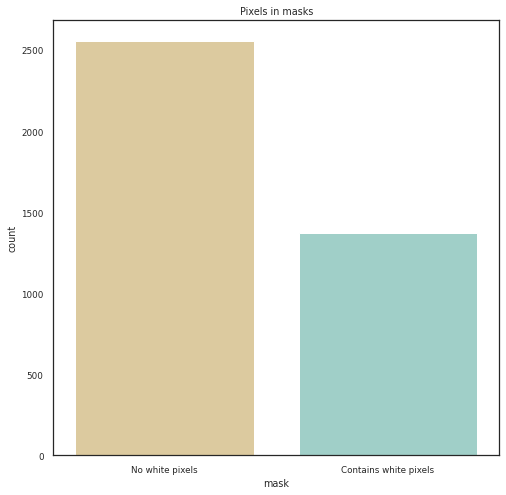

In [ ]:
sns.set(rc={ 'figure.figsize':(8.0, 8.0) }, style='white', font_scale=0.8)
sns.countplot(x='mask', data=brain_df, palette='BrBG')

plt.title('Pixels in masks')
plt.xticks(ticks=[0, 1], labels=['No white pixels', 'Contains white pixels'])

plt.show()

Text(0.5, 1.0, 'MRI Scan')

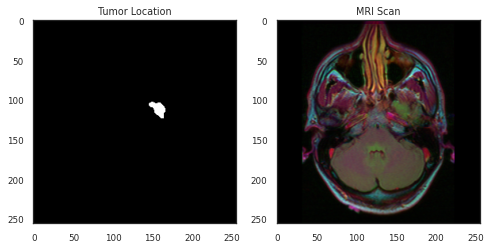

In [ ]:
# Traverse and select the first mri scan that has a valid mask 
for i in range(len(brain_df)):
    if cv2.imread(brain_df.mask_path[i]).max() > 0:
        break

# Display 
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(cv2.imread(brain_df.mask_path[i]));
plt.title('Tumor Location')

plt.subplot(1,2,2)
plt.imshow(cv2.imread(brain_df.image_path[i]));
plt.title('MRI Scan')

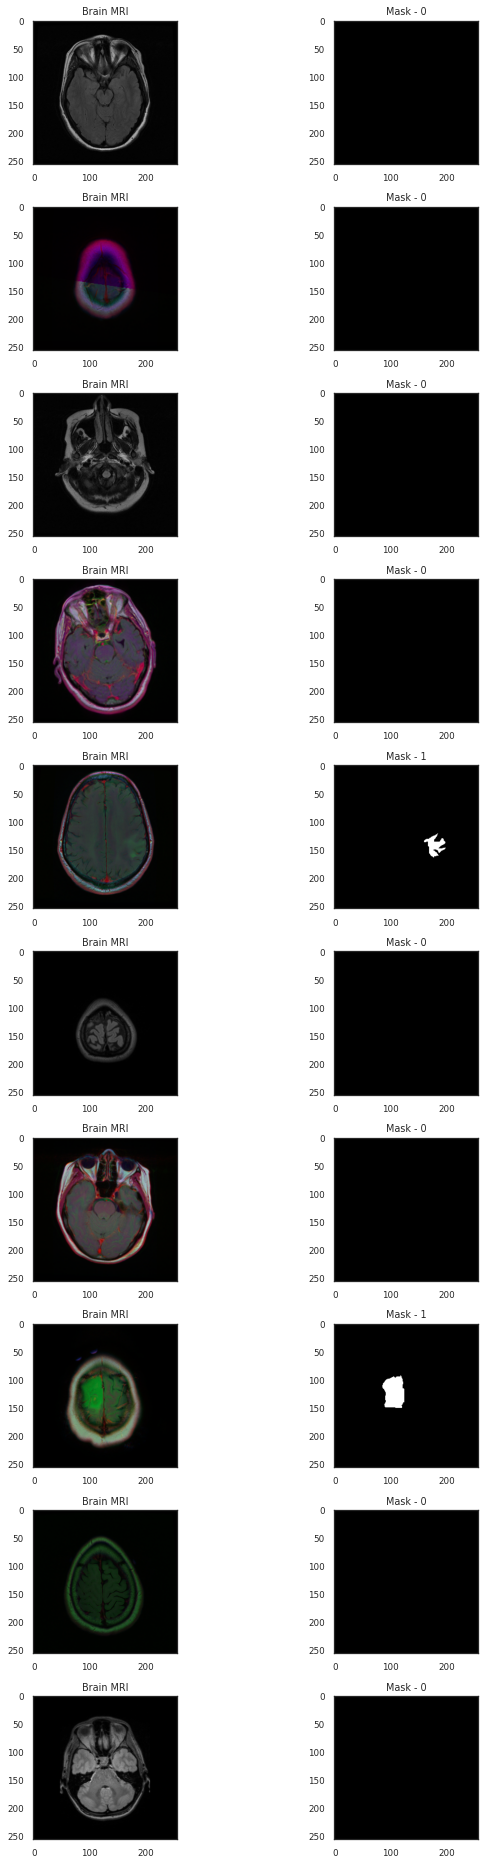

In [ ]:
# Visualization of Brain MRI scans and Mask images
# - randomly select 10 pairs of mri-scan and masks

# Create 10x2 plot figure (10 rows x 2 cols)
fig, axs = plt.subplots(10,2, figsize=(10,26))

for x in range(10):
  i = random.randint(0, len(brain_df)) # select a random index

  axs[x][0].title.set_text("Brain MRI") # MRI title
  axs[x][0].imshow(cv2.imread(brain_df.image_path[i])) # show MRI 

  axs[x][1].title.set_text("Mask - " + str(brain_df['mask'][i])) # Mask title (0 or 1)
  axs[x][1].imshow(cv2.imread(brain_df.mask_path[i])) # show corresponding mask

fig.tight_layout()

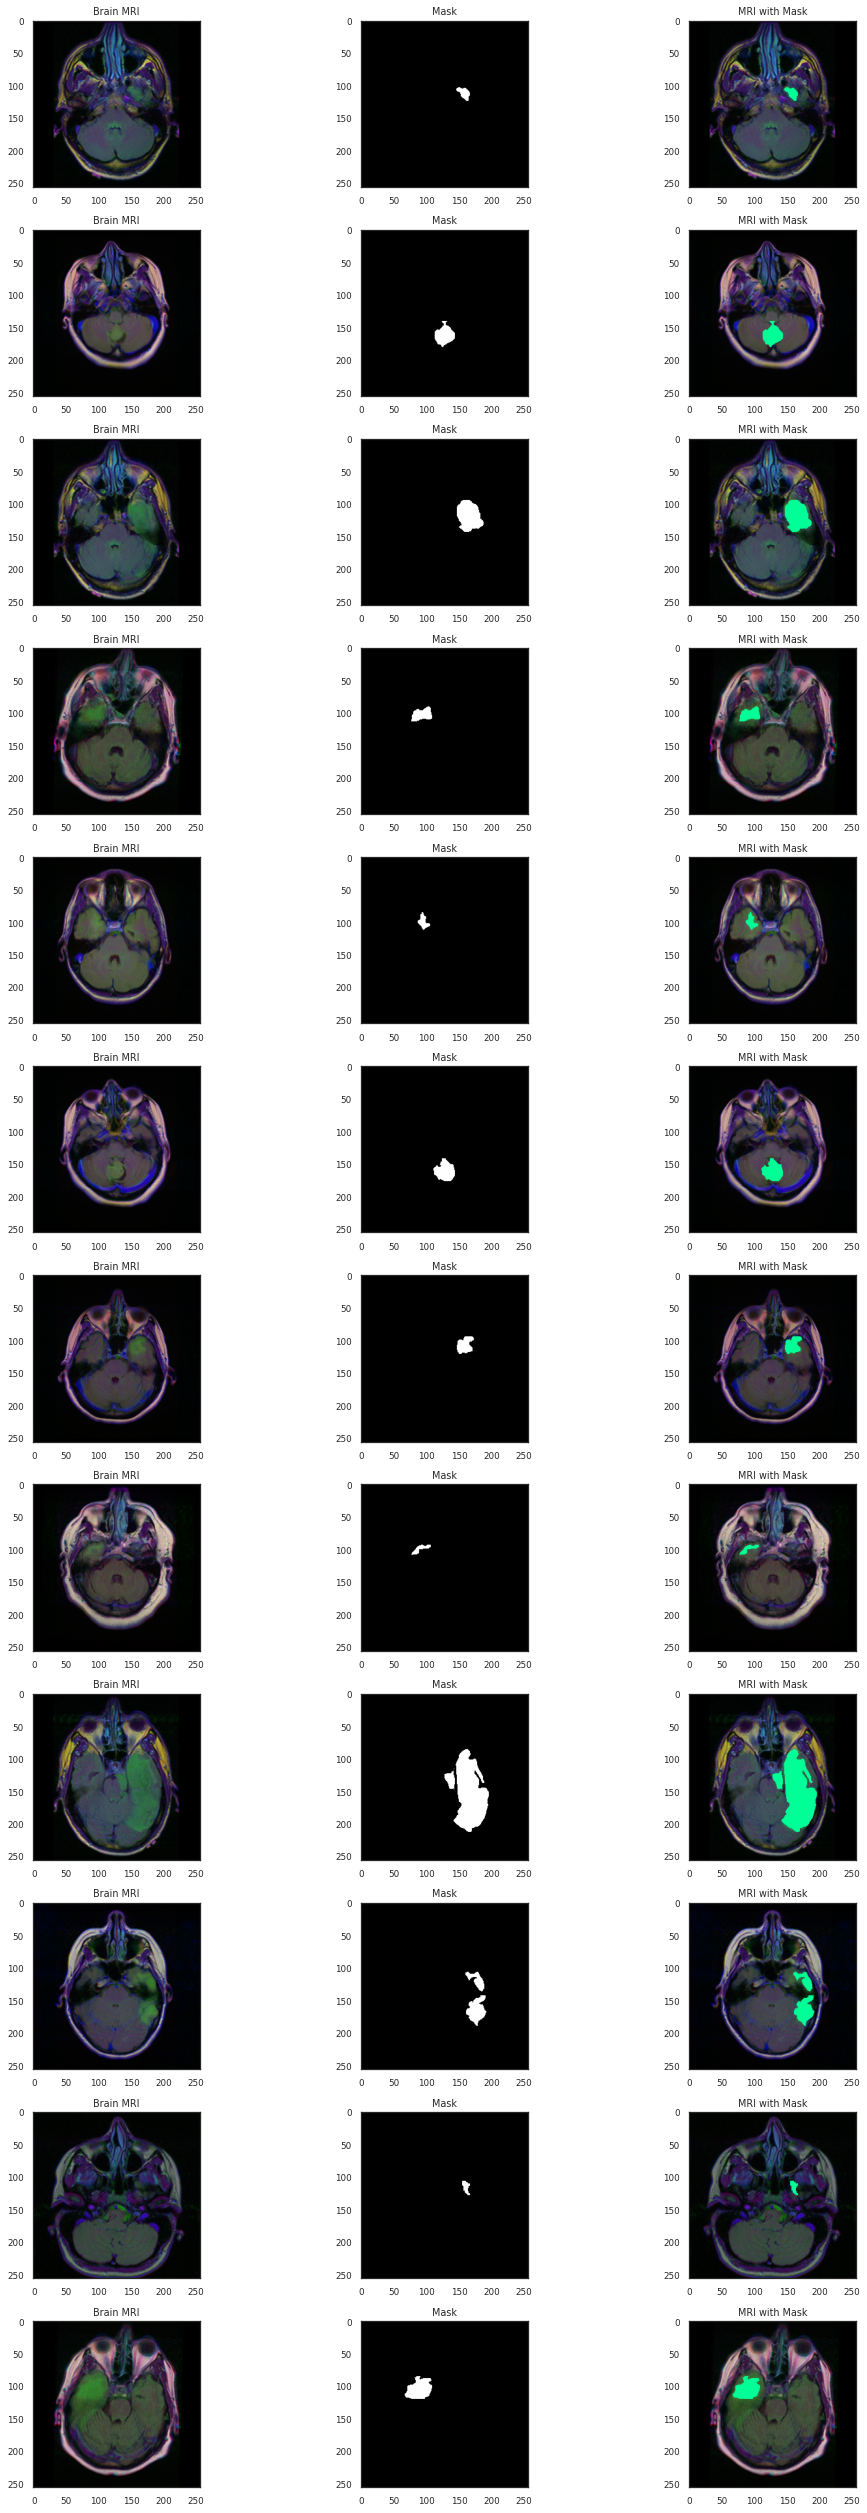

In [ ]:
fig,axs = plt.subplots(12,3, figsize=(15,35))

count = 0
for i, mask in enumerate(brain_df['mask']):
    if (mask==1):
        
        img = io.imread(brain_df.image_path[i])
        axs[count][0].title.set_text("Brain MRI")
        axs[count][0].imshow(img)
        
        mask = io.imread(brain_df.mask_path[i])
        axs[count][1].title.set_text("Mask")
        axs[count][1].imshow(mask, cmap='gray')
        
        img[mask==255] = (0,255,150)  # change pixel color at the position of mask
        axs[count][2].title.set_text("MRI with Mask")
        axs[count][2].imshow(img)
        
        count +=1

    if (count==12):
        break
        
fig.tight_layout()

## 05. Data Preparation

In [ ]:
brain_df

,patient_id,image_path,mask_path,mask
0,TCGA_HT_7684_19950816,/content/kaggle_3m/TCGA_HT_7684_19950816/TCGA_...,/content/kaggle_3m/TCGA_HT_7684_19950816/TCGA_...,0
1,TCGA_HT_7684_19950816,/content/kaggle_3m/TCGA_DU_5849_19950405/TCGA_...,/content/kaggle_3m/TCGA_DU_5849_19950405/TCGA_...,0
2,TCGA_HT_7684_19950816,/content/kaggle_3m/TCGA_DU_5871_19941206/TCGA_...,/content/kaggle_3m/TCGA_DU_5871_19941206/TCGA_...,0
3,TCGA_HT_7684_19950816,/content/kaggle_3m/TCGA_DU_6408_19860521/TCGA_...,/content/kaggle_3m/TCGA_DU_6408_19860521/TCGA_...,0
4,TCGA_HT_7684_19950816,/content/kaggle_3m/TCGA_CS_5393_19990606/TCGA_...,/content/kaggle_3m/TCGA_CS_5393_19990606/TCGA_...,0
...,...,...,...,...
3924,TCGA_DU_6399_19830416,/content/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_...,/content/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_...,0
3925,TCGA_DU_6399_19830416,/content/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_...,/content/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_...,0
3926,TCGA_DU_6399_19830416,/content/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_...,/content/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_...,0
3927,TCGA_DU_6399_19830416,/content/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_...,/content/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_...,0


In [ ]:
brain_df_src = brain_df.drop(columns=['patient_id'])
brain_df_src

,image_path,mask_path,mask
0,/content/kaggle_3m/TCGA_HT_7684_19950816/TCGA_...,/content/kaggle_3m/TCGA_HT_7684_19950816/TCGA_...,0
1,/content/kaggle_3m/TCGA_DU_5849_19950405/TCGA_...,/content/kaggle_3m/TCGA_DU_5849_19950405/TCGA_...,0
2,/content/kaggle_3m/TCGA_DU_5871_19941206/TCGA_...,/content/kaggle_3m/TCGA_DU_5871_19941206/TCGA_...,0
3,/content/kaggle_3m/TCGA_DU_6408_19860521/TCGA_...,/content/kaggle_3m/TCGA_DU_6408_19860521/TCGA_...,0
4,/content/kaggle_3m/TCGA_CS_5393_19990606/TCGA_...,/content/kaggle_3m/TCGA_CS_5393_19990606/TCGA_...,0
...,...,...,...
3924,/content/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_...,/content/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_...,0
3925,/content/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_...,/content/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_...,0
3926,/content/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_...,/content/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_...,0
3927,/content/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_...,/content/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_...,0


In [ ]:
brain_df_src.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 92.2+ KB


In [ ]:
brain_df_src['mask'] = brain_df_src['mask'].astype('string')
brain_df_src.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   string
dtypes: object(2), string(1)
memory usage: 92.2+ KB


In [ ]:
BATCH_SIZE = 32
IMG_SHAPE = 256

In [ ]:
class_weight = {0: weight_absent, 1: weight_present}

In [ ]:
# This function will plot images in the form of a grid with 1 row and 5 columns 
# where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

### Split into train, test, and validation sets

In [ ]:
from sklearn.model_selection import train_test_split
from keras_preprocessing.image import ImageDataGenerator

# First split into train and test sets at 80:20 ratio
# Second split into train validation at 75:25 ratio
# - results in 60:20:20 ratio (train, val, test)
train, test = train_test_split(brain_df_src, test_size=0.2, random_state=1)
train, val = train_test_split(train, test_size=0.25, random_state=1)

### Data Generation and Augmentation

Found 2357 validated image filenames belonging to 2 classes.


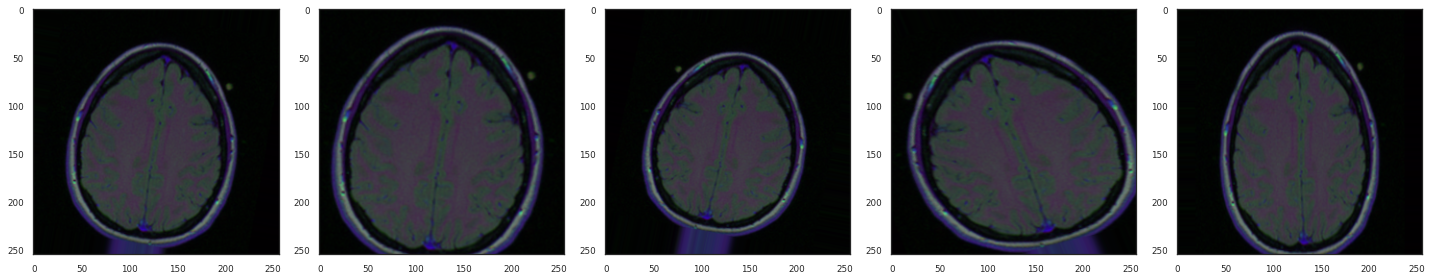

In [ ]:
# TRAIN
image_gen_train = ImageDataGenerator(rescale=1./255., 
                                     horizontal_flip=True, 
                                     rotation_range=20, 
                                     zoom_range=0.2)

train_data_gen = image_gen_train.flow_from_dataframe(
    train,
    directory='./',
    x_col='image_path',
    y_col='mask',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    target_size=(IMG_SHAPE,IMG_SHAPE)
)

augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [ ]:
# VALID
image_gen_val = ImageDataGenerator(rescale=1./255.)
val_data_gen = image_gen_val.flow_from_dataframe(
    val,
    directory='./',
    x_col='image_path',
    y_col='mask',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    target_size=(IMG_SHAPE,IMG_SHAPE)
)

Found 786 validated image filenames belonging to 2 classes.


In [ ]:
# TEST
image_gen_test = ImageDataGenerator(rescale=1./255.)
test_data_gen = image_gen_test.flow_from_dataframe(
    test,
    directory='./',
    x_col='image_path',
    y_col='mask',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False,
    target_size=(IMG_SHAPE,IMG_SHAPE)
)

Found 786 validated image filenames belonging to 2 classes.


## 06. Create CNN Model

Use transfer learning from preset ResNet50 network.

Refer to: https://www.tensorflow.org/tutorials/images/transfer_learning

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50

base_model = ResNet50(weights='imagenet', 
                      include_top=False, 
                      input_tensor=Input(shape=(IMG_SHAPE,IMG_SHAPE,3)))

94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

Freeze the convolutional base


In [ ]:
base_model.trainable = False

In [ ]:
head = base_model.output

head = MaxPooling2D(pool_size=(4,4))(head)
head = Flatten(name='Flatten')(head)

# head = Dense(128, activation='elu')(head)
# head = Dropout(0.3)(head)

head = Dense(256, activation='elu')(head)
head = Dropout(0.3)(head)

head = Dense(2, activation='softmax')(head)

model = Model(base_model.input, head)

In [ ]:
# x = base_model.output

# x = tf.keras.layers.MaxPooling2D(pool_size=(4, 4))(x)
# x = tf.keras.layers.Flatten()(x)

# x = tf.keras.layers.Dense(128, activation='relu')(x)
# x = tf.keras.layers.Dropout(0.2)(x)

# x = tf.keras.layers.Dense(128, activation='relu')(x)
# x = tf.keras.layers.Dropout(0.2)(x)

# output = tf.keras.layers.Dense(2)(x)

# model = Model(base_model.input, output)

In [ ]:
# model = tf.keras.models.Sequential([
                                    
#     tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(IMG_SHAPE,IMG_SHAPE,3)),
#     tf.keras.layers.MaxPooling2D(pool_size=(4, 4)),

#     tf.keras.layers.Conv2D(512, (3,3), padding='same', activation='relu'),
#     tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),

#     tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
#     tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),

#     tf.keras.layers.Flatten(),

#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(128, activation='relu'),

#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(2)
# ])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

## Compile the Model

In [ ]:
# Create optimizer
# opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
opt = 'adam'
lss = 'categorical_crossentropy'

# Compile the model
model.compile(optimizer=opt,
              loss=lss,
              metrics=['accuracy'])

In [ ]:
# Earlystopping will stop the learning process when there are no
# ten consecutive improvements in the val_loss.
earlystopping = EarlyStopping(monitor='val_loss', 
                              mode='min',
                              verbose=1,
                              patience=15)

# Create a checkpoint based on val_loss
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath="my_checkpoint.h5",
                                                verbose=1, 
                                                save_best_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=5,
                              min_delta=0.0001,
                              factor=0.2)

In [ ]:
history = model.fit(train_data_gen, 
                    epochs=100, 
                    steps_per_epoch=int(np.ceil(train_data_gen.n / float(BATCH_SIZE))),
                    validation_data=val_data_gen,
                    validation_steps=int(np.ceil(val_data_gen.n / float(BATCH_SIZE))),
                    # class_weight=class_weight, 
                    callbacks=[checkpoint, earlystopping, reduce_lr])

Epoch 1/100
74/74 [==============================] - 47s 503ms/step - loss: 3.8772 - accuracy: 0.5693 - val_loss: 0.6807 - val_accuracy: 0.6361

Epoch 00001: val_loss improved from inf to 0.68070, saving model to my_checkpoint.h5
Epoch 2/100
74/74 [==============================] - 36s 487ms/step - loss: 0.7846 - accuracy: 0.6161 - val_loss: 0.5786 - val_accuracy: 0.6858

Epoch 00002: val_loss improved from 0.68070 to 0.57857, saving model to my_checkpoint.h5
Epoch 3/100
74/74 [==============================] - 36s 490ms/step - loss: 0.7459 - accuracy: 0.6237 - val_loss: 0.5478 - val_accuracy: 0.7226

Epoch 00003: val_loss improved from 0.57857 to 0.54778, saving model to my_checkpoint.h5
Epoch 4/100
74/74 [==============================] - 36s 486ms/step - loss: 0.7077 - accuracy: 0.6393 - val_loss: 0.5400 - val_accuracy: 0.7226

Epoch 00004: val_loss improved from 0.54778 to 0.53996, saving model to my_checkpoint.h5
Epoch 5/100
74/74 [==============================] - 36s 486ms/step 

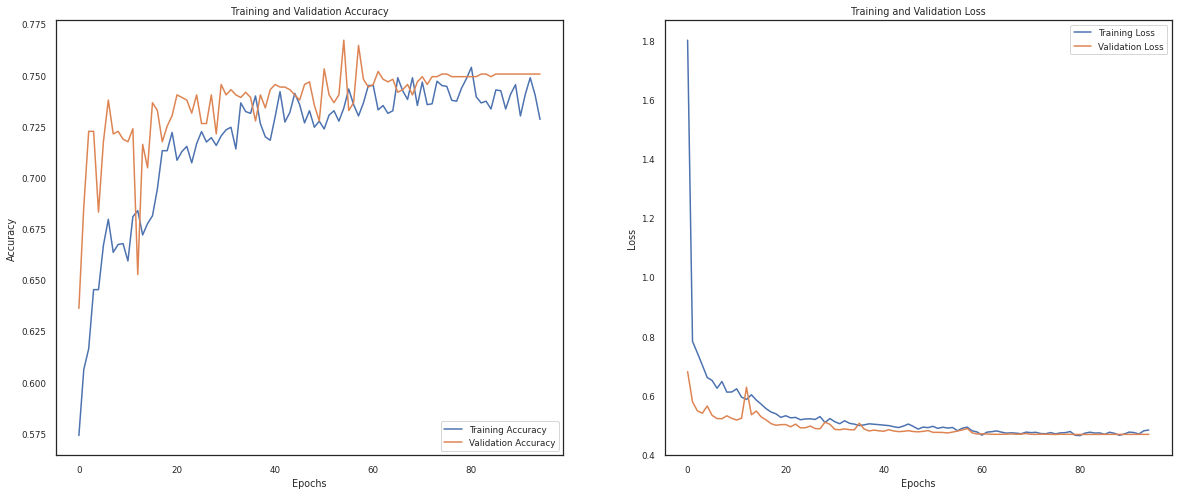

In [ ]:
# Accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Loss
loss = history.history['loss']
val_loss = history.history['val_loss']

# First figure: Model Accuracy
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Second figure: Model Loss
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()